# KKBox Customer Churn Prediction
### w/ BigQuery and Apache Spark

---

# Part II: <font color=green>*Exploratory Data Analysis*</font>

---

In [1]:
# Imports for BigQuery connection
# import json
# import pprint
# import subprocess
# from google.cloud import bigquery
import warnings
warnings.filterwarnings('ignore')

# General Imports for BigQuery connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

#### - <font color=blue>Connect to BigQuery</font> -

In [2]:
# # Specify Google Credentials
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='D:\OneDrive\J-5\GitHub\Google Credentials.json'

In [3]:
# # Instantiate BigQuery extension
# bigquery_client = bigquery.Client(project='spark-kkbox')

# # Instantiate BigQuery magic
# %load_ext google.cloud.bigquery

In [4]:
# For Loop to create three samples for each type
for x in [1,2,3]:
    # Create three stratified samples
    balance_churn_0 = f"""
                SELECT 
                 *
                FROM `spark-kkbox.KKbox_User_Data.DRV_Jan2016`
                WHERE is_churn = 0
                ORDER BY RAND()
                LIMIT 18865
             """
    balance_churn_1 = f"""
                SELECT 
                 *
                FROM `spark-kkbox.KKbox_User_Data.DRV_Jan2016`
                WHERE is_churn = 1
                 """

    # Call .query() followed by .to_dataframe() to trigger the 'lazy function'
    balance_churn_0 = bigquery_client.query(balance_churn_0).to_dataframe()
    balance_churn_1 = bigquery_client.query(balance_churn_1).to_dataframe()
    
    # Combine respective dataframes into sets
    exec(f'balancedf_{x} = pd.concat((balance_churn_0, balance_churn_1))')

#### - <font color=blue>Create Stratified Samples</font> -

In [4]:
# Import Data
DRV_Jan20160 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000000')
DRV_Jan20161 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000001')
DRV_Jan20162 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000002')


DRV_Jan2016 = pd.concat([DRV_Jan20160,DRV_Jan20161,DRV_Jan20162])

DRV_Jan20160 = 0
DRV_Jan20161 = 0
DRV_Jan20162 = 0

In [ ]:
DRV_Jan2016

#### - <font color=blue>Split Feautres by Categorical or Continuous</font> -

In [6]:
# Create list of Categorical feature names
cat_feats = ['is_net_paid_amount', 'is_auto_renew', 'registered_via', 'never_active_subscriber', 'total_spent_zero', 'city_agg', 'payment_method_agg']

In [7]:
# Create list of Continuous feature names
cont_feats = [x for x in DRV_Jan2016.columns.tolist() if x not in cat_feats]
cont_feats.remove('msno')
cont_feats.remove('is_churn')
cont_feats.remove('membership_expire_date')
cont_feats.remove('registration_init_time')
cont_feats.remove('city')
cont_feats.remove('bd')
cont_feats.remove('payment_method_id')

#### - <font color=blue>Preview Target Variable</font> -

In [9]:
# Print out binary counts and their relative frequency - Balanced Data
totals = DRV_Jan2016['is_churn'].value_counts() 
relative = DRV_Jan2016['is_churn'].value_counts() / DRV_Jan2016['is_churn'].value_counts().sum()

targetVar_dist = pd.concat([totals, relative], axis=1, keys=['Total Count', 'Relative %'])
targetVar_dist

,Total Count,Relative %
0,672751,0.972325
1,19148,0.027675


#### - <font color=blue>Continuous Feature Univariate Analysis</font> -

NameError: name 'df' is not defined

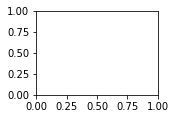

In [9]:
# Display Histogram for each Continuous Feature
plt.figure(figsize=(10,20))
for index, column in enumerate(cont_feats):
    plt.subplot(11,4,index+1)
    plt.hist(df[column], bins=100)
    plt.title(f"{column} Distribution")
    plt.xlabel(f'{column}')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

#### - <font color=blue>Target Variable vs Continuous Features</font> -

Here we will evaluate each feature against our binary target variable ***is_churn*** via a T-Test to see whether or not the respective features are statistically significant. We will do this for each sample set that we have.

#### <font color=purple>*Independent T-Tests: Continuous Feature Values and their respective Churn Categorical Values*</font>

When performing Exploratory Data Analysis on large feature sets I like to take a statistical approach in the beginning to set the direction. In the spirit of this, we will start off by performing an Independent T-Test of all Continuous Features by splitting their values on our target's categorical values, and then running the test against themselves.

By doing this I am looking to understand if there is a significant difference within these Features when Churn is 0 and 1.

In [10]:
# Conduct Independent T-Test.
# Does user churn affect the probability of being part of a specific category
# Ho: Observed Values are from the Population. Difference is due to Random Variation

# Iterate through sample dictionary
for name, sample in samp_dict.items():

    # Create empty dataframe
    print(f'================= {name} =================')
    ttest_results = pd.DataFrame(columns=['Feature','t-Stat','p-value'])

    # Populate dataframe with T-test results
    unique_cats = sample["is_churn"].unique()
    grouped_df = sample.groupby("is_churn")
    for feature in cont_feats:
        for i in range(0, len(unique_cats)):
            for j in range(i+1, len(unique_cats)):
                x = stats.ttest_ind(sample[sample["is_churn"]==unique_cats[i]][feature], sample[sample["is_churn"]==unique_cats[j]][feature])
                ttest_results = ttest_results.append({'Feature':f'{feature}','t-Stat':f'{x.statistic}','p-value':f'{x.pvalue:1.4f}'}, ignore_index=True)
    print(f'''
    {ttest_results.sort_values('p-value',ascending=False).head(20)}\n
    ''')

================= balancedf_1 =================

                              Feature               t-Stat p-value
212      DIFAVG_songs_30_45_45_60  0.23127500267032838  0.8171
211      DIFSUM_songs_30_45_45_60  0.23127500267032775  0.8171
223    DIFAVG_repeats_30_45_45_60  -0.9482780775293959  0.3430
222    DIFSUM_repeats_30_45_45_60   -0.948278077529396  0.3430
91            total_secs_last_120  -0.9925820087677314  0.3209
92        total_secs_last_120_AVG  -0.9925820087677311  0.3209
208  DIFSUM_unq_songs_30_45_45_60   1.0037162444722718  0.3155
209  DIFAVG_unq_songs_30_45_45_60    1.003716244472272  0.3155
19              spent_per_num_unq   1.2359853395818219  0.2165
7                      total_secs  -1.4037592753100336  0.1604
215       DIFAVG_secs_30_45_45_60   -1.408192129010699  0.1591
214       DIFSUM_secs_30_45_45_60  -1.4081921290106985  0.1591
20          spent_per_num_repeats   2.0606947713458617  0.0393
224    DIFSTD_repeats_30_45_45_60    2.061965518445549  0.0392
21

In [11]:
cont_feats_nonsig = [
'DIFAVG_logins_30_45_45_60',
'DIFSUM_logins_30_45_45_60',
'DIFAVG_unq_songs_30_45_45_60',
'DIFSUM_unq_songs_30_45_45_60',   
'total_secs',
'total_secs_last_120',       
'spent_per_song',         
'DIFSUM_secs_30_45_45_60',
]

We run our T-Test on all six sample sets so we can get sense of consitency in our results. We see that these features seem to be statistically insignificant:
***'total_secs','spent_per_secs','spent_per_song','spent_per_logins','spent_per_num_repeats','total_secs***

Let's visually compare them with boxplots and then look at their respective 5-Number Summaries if the visual distributions are too hard to tell apart.

#### <font color=purple>*Box Plots: 'Statistically Insignificant' Continuous Features vs Churn*</font>

================= balancedf_1 =================


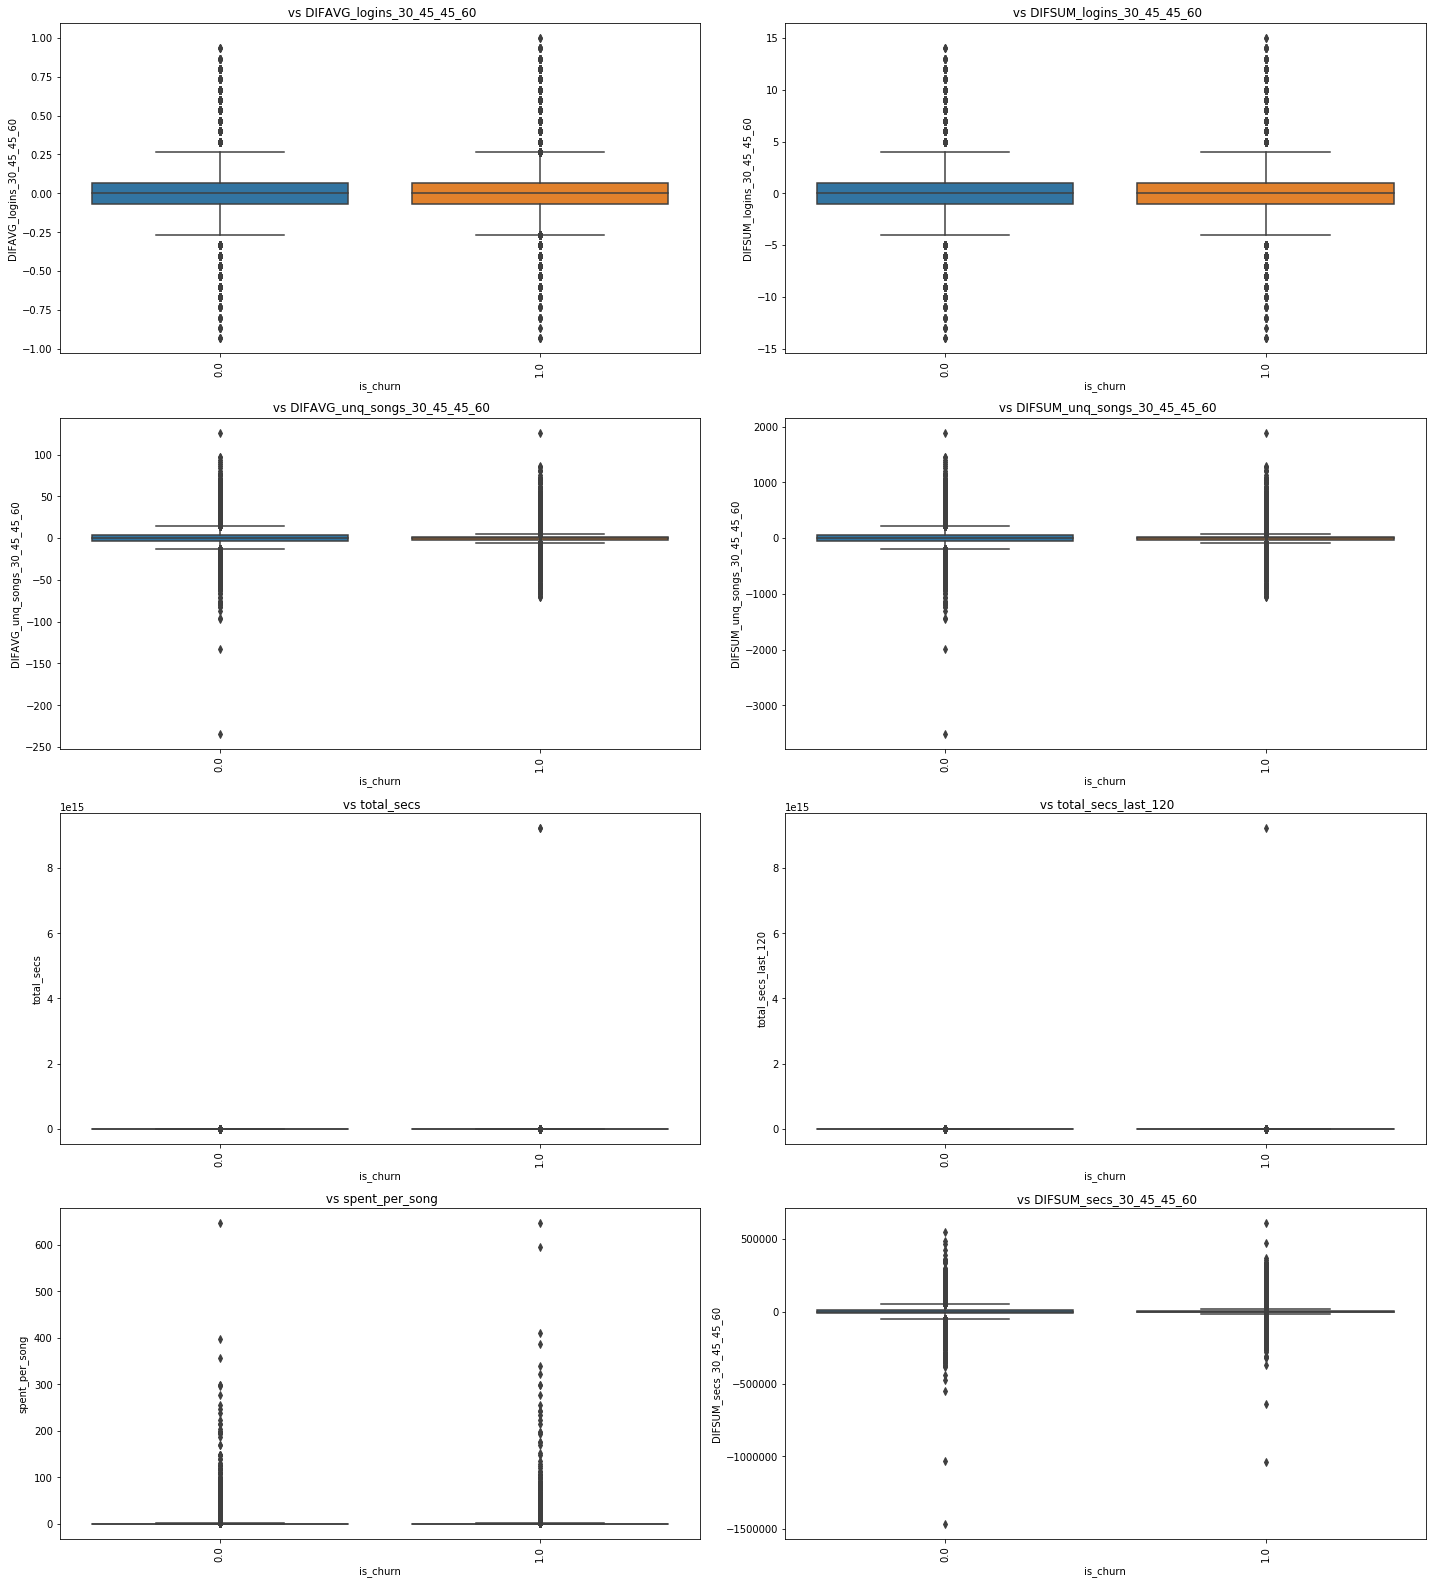

================= balancedf_2 =================


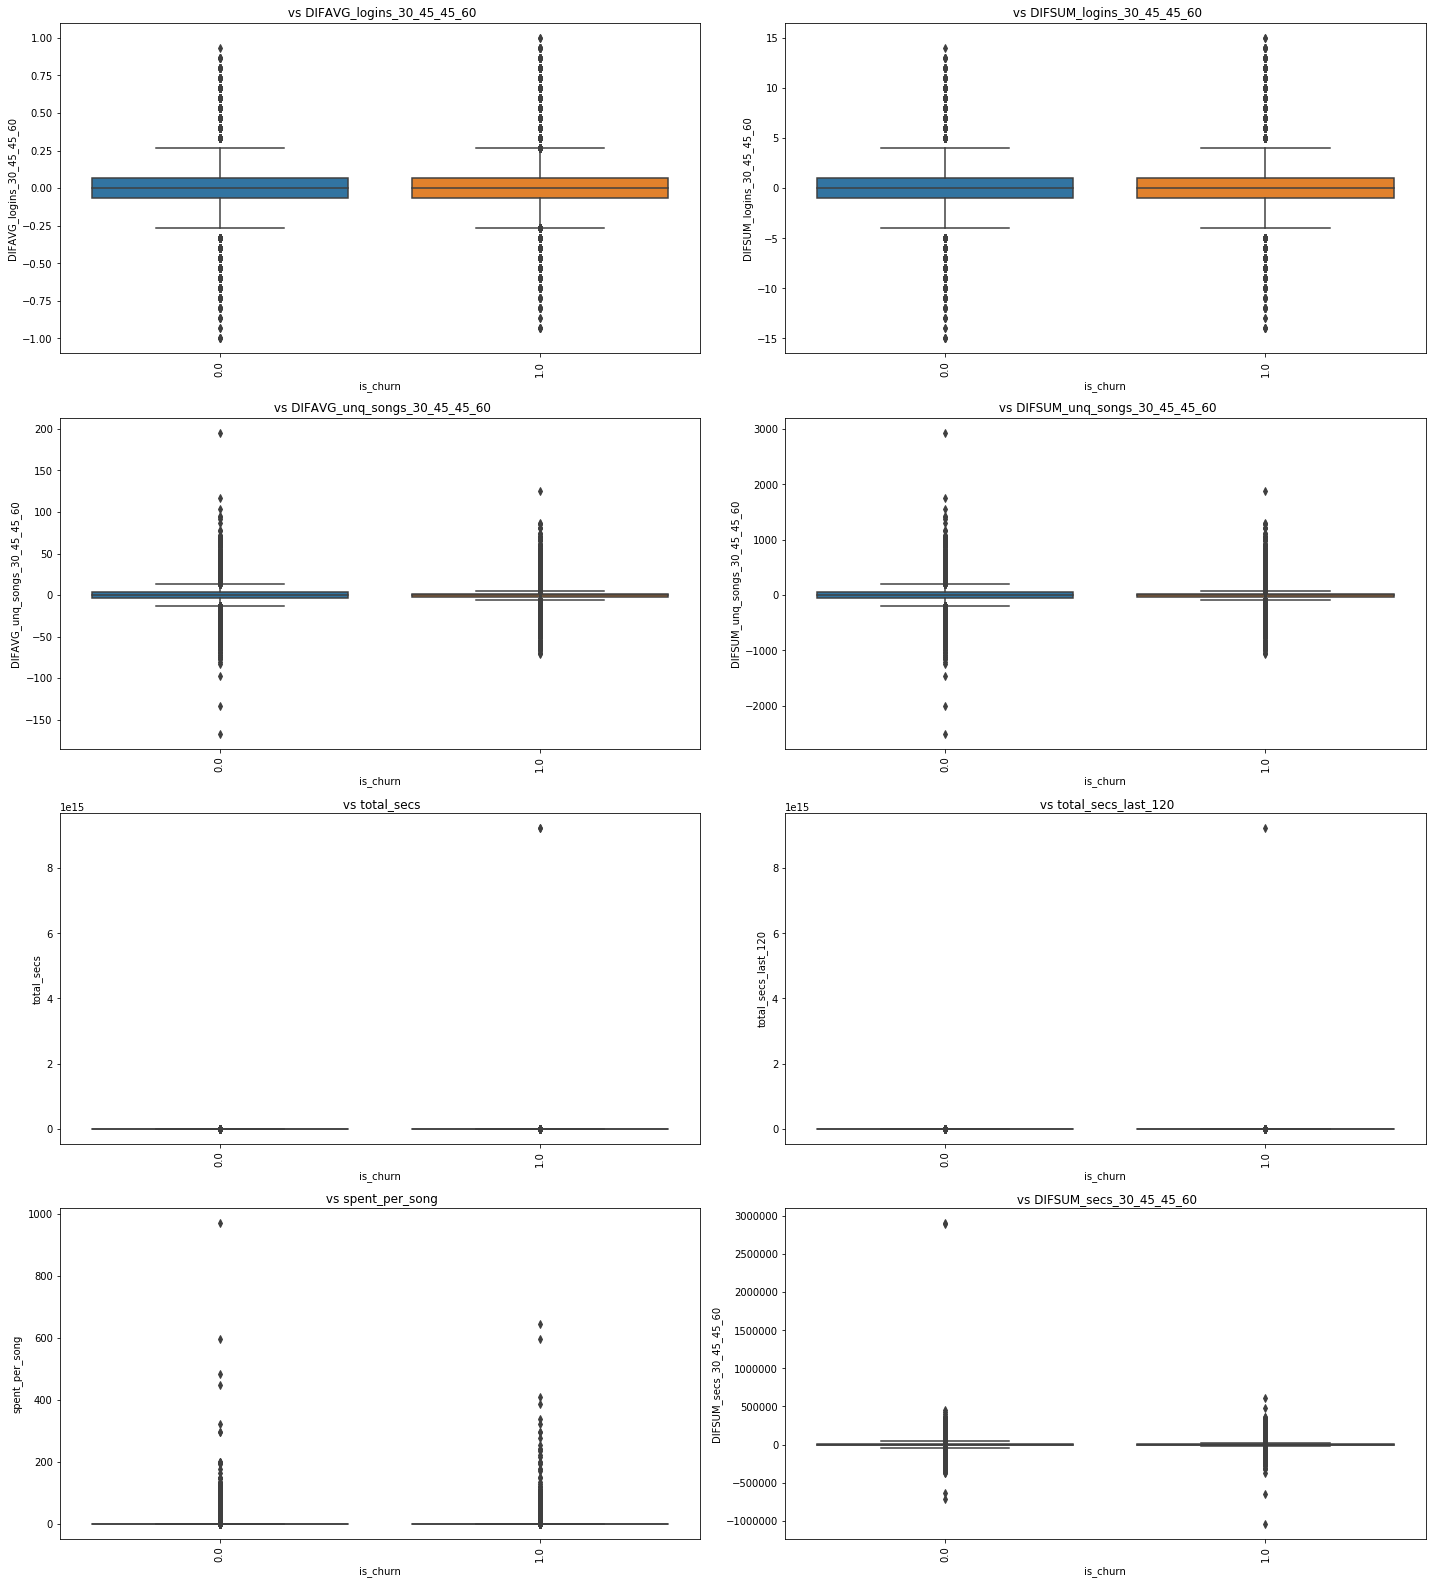

================= balancedf_3 =================


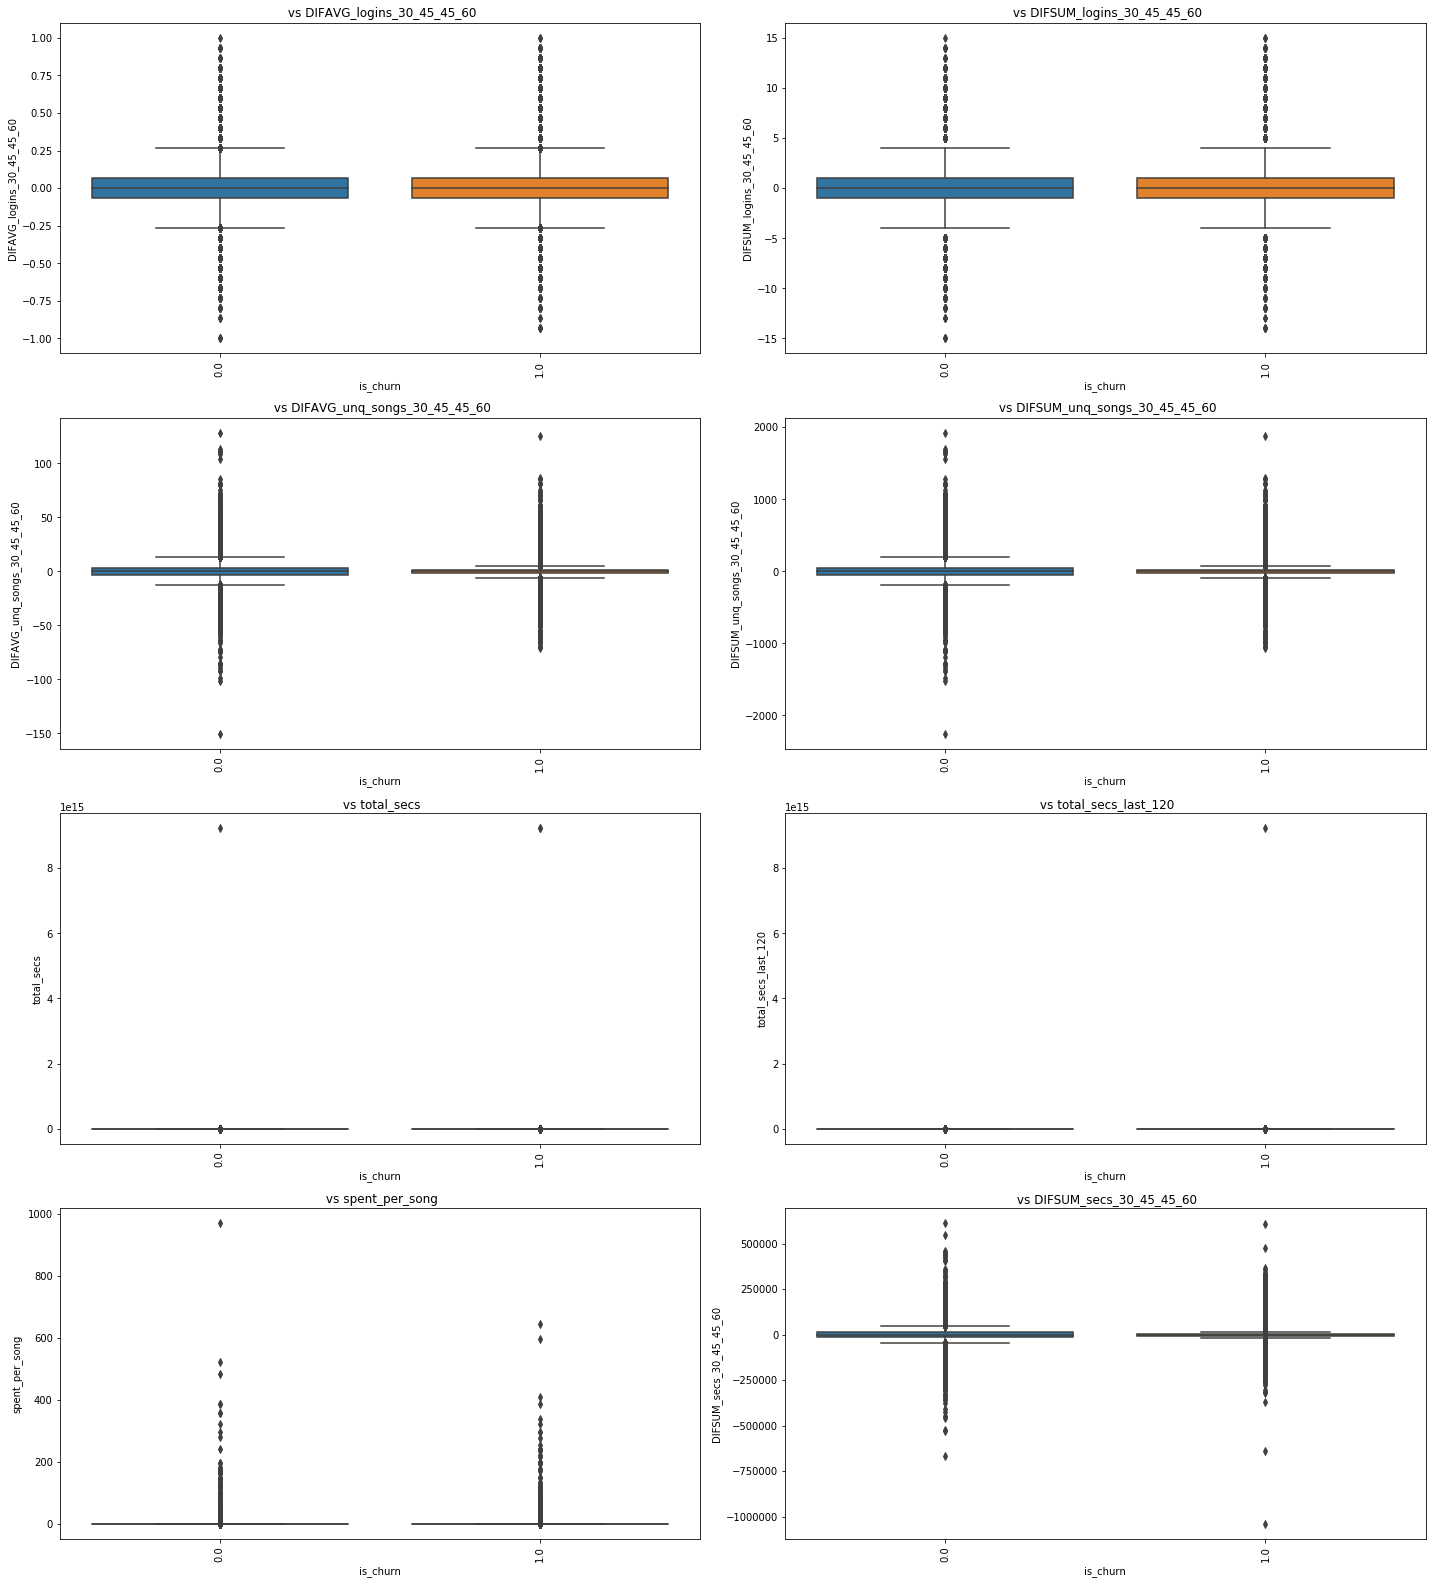

In [24]:
# Visualize Churn vs Non-Significant Features (Continuous)

# # Create list of all non-significant
# cont_feats_nonsig = ['total_secs','spent_per_secs','spent_per_song','spent_per_logins','spent_per_num_repeats']

# Iterate through dictionary of samples
for name, sample in samp_dict.items():
    
    # Plot features as BoxPlots
    print(f'================= {name} =================')
    plt.figure(figsize=(20,60))
    for index, feature in enumerate(cont_feats_nonsig):
        plt.subplot(11,2,index+1)
        sns.boxplot(sample['is_churn'],sample[feature])
        plt.title(f" vs {feature}")
        plt.ylabel(feature)
        plt.xlabel('is_churn')
        plt.xticks(rotation='vertical')

    plt.tight_layout()
    plt.show()

All we can really tell from this is that for nearly all the plots the majority of the values seem to be focused around the Zero mark with very long tails. On both stratified and balanced sample sets, we can see that when ***'is_churn' = 1*** the box plots have a slight amount of more body than the counterpart.

However, we can clearly see that the ***'is_churn' = 0*** boxplots have longer tails in the stratified sample sets. So although they are not statistically significant, I do expect these features to explain some level of variability in our model. To get a better understanding of these distributions, let's take a look at the 5-Number Summary for each feature against 'is_churn'.

#### <font color=purple>*5 Number Summaries: 'Statistically Insignificant' Continuous Features*</font>

In [13]:
# Analyze 5-Number Summary for each feature against 'is_churn'
for sample in ['balancedf_1']:
    print(f'''#-#-#-#-#-# {str.upper(sample)} #-#-#-#-#-# \n''')
    for feature in cont_feats_nonsig:
        print(f'''====== {feature} ====== 
    {samp_dict[sample].groupby('is_churn')[feature].describe()}\n
    Medians \n
    {samp_dict[sample].groupby('is_churn')[feature].median()}\n
''')

#-#-#-#-#-# BALANCEDF_1 #-#-#-#-#-# 

====== DIFAVG_logins_30_45_45_60 ====== 
                count      mean       std       min       25%  50%       75%  \
is_churn                                                                   
0.0       18865.0  0.009545  0.191606 -0.933333 -0.066667  0.0  0.066667   
1.0       19148.0  0.005170  0.188254 -0.933333 -0.066667  0.0  0.066667   

               max  
is_churn            
0.0       0.933333  
1.0       1.000000  

    Medians 

    is_churn
0.0    0.0
1.0    0.0
Name: DIFAVG_logins_30_45_45_60, dtype: float64


====== DIFSUM_logins_30_45_45_60 ====== 
                count      mean       std   min  25%  50%  75%   max
is_churn                                                        
0.0       18865.0  0.143175  2.874092 -14.0 -1.0  0.0  1.0  14.0
1.0       19148.0  0.077554  2.823806 -14.0 -1.0  0.0  1.0  15.0

    Medians 

    is_churn
0.0    0.0
1.0    0.0
Name: DIFSUM_logins_30_45_45_60, dtype: float64


====== DIFAVG_unq_songs

In all of the ***spent_per*** features the distributions are as expected; close without much variance between the binary 'is_churn' values. However, with **total_secs** the distributions do we seem a bit more father apart from each other and although it is considered *insignificant* I do expect it to help explain some of the variation in our model. 

#### <font color=purple>*Box Plots: 'Statistically Significant' Continuous Features vs Churn*</font>

#-#-#-#-#-# BALANCEDF_1 #-#-#-#-#-# 



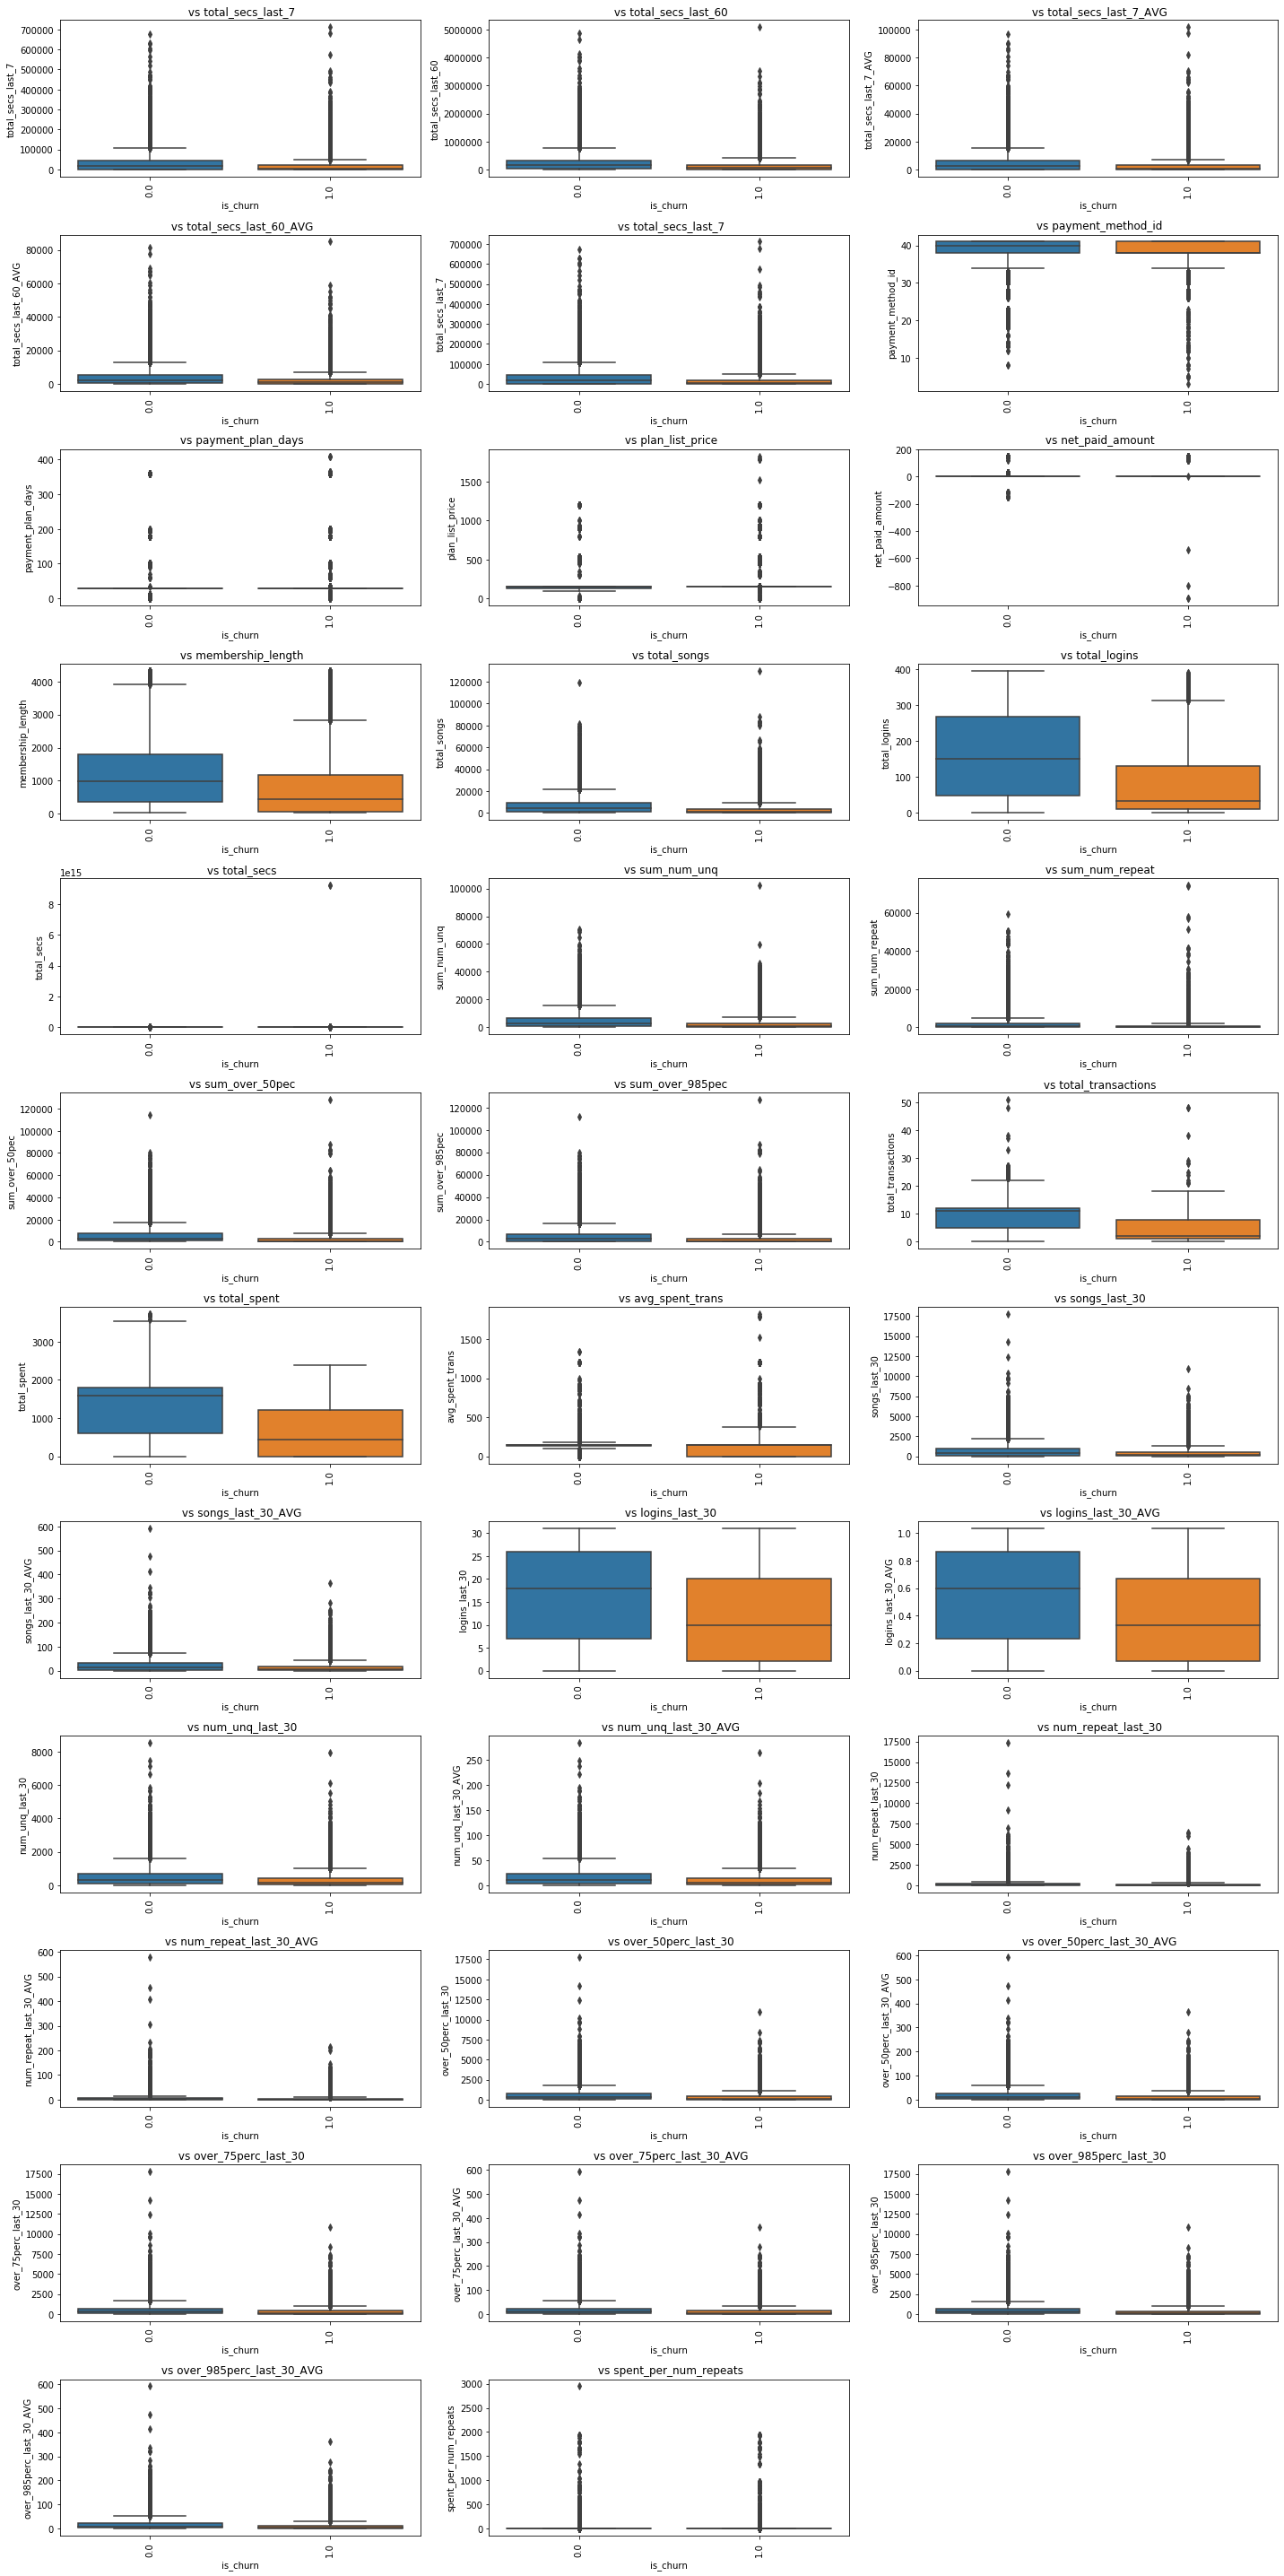

In [34]:
# Visualize Churn vs Significant Features (Continuous)

# Create list of select, significant features
cont_feats_sig= ['total_secs_last_7','total_secs_last_60','total_secs_last_7_AVG','total_secs_last_60_AVG',
                     'total_secs_last_7','payment_method_id','payment_plan_days','plan_list_price','net_paid_amount','membership_length','total_songs',
                     'total_logins','total_secs','sum_num_unq','sum_num_repeat','sum_over_50pec','sum_over_985pec','total_transactions',
                     'total_spent','avg_spent_trans','songs_last_30','songs_last_30_AVG','logins_last_30','logins_last_30_AVG','num_unq_last_30',
                     'num_unq_last_30_AVG','num_repeat_last_30','num_repeat_last_30_AVG','over_50perc_last_30','over_50perc_last_30_AVG','over_75perc_last_30',
                     'over_75perc_last_30_AVG','over_985perc_last_30','over_985perc_last_30_AVG','spent_per_num_repeats']

# Create visualizations for each sample
for sample in ['balancedf_1']:
    print(f'''#-#-#-#-#-# {str.upper(sample)} #-#-#-#-#-# \n''')
    
    # Plot features as BoxPlots
    plt.figure(figsize=(20,40))
    for index, feature in enumerate(cont_feats_sig):
        plt.subplot(12,3,index+1)
        sns.boxplot(samp_dict[sample]['is_churn'],samp_dict[sample][feature])
        plt.title(f" vs {feature}")
        plt.ylabel(feature)
        plt.xlabel('is_churn')
        plt.xticks(rotation='vertical')

    plt.tight_layout()
    plt.show()

Noticeably we can see that these plots have more body which makes them a lot easier to compare. For both stratified and balanced sample sets, there is not much of a difference. I expect all of these features to have some influence on our model.

#### - <font color=blue>Categorical Feature Univariate Analysis</font> -

Now let's switch things up and look at our Categorical Variables. First we will start by looking at the frequency tables of each feature in both types of sample sets. I am looking to see if there is a notable difference in the distributions from one set to another.

#### <font color=purple>*Frequency Tables of Categorical Features*</font>

In [15]:
# Create visualizations for each sample
# for sample in ['stratdf_1', 'balancedf_1']:
#     print(f'''#-#-#-#-#-# {str.upper(sample)} #-#-#-#-#-# \n''')

# Print out Binary counts and their relative frequency
for column in cat_feats:
    for sample in ['balancedf_1']:
        totals = samp_dict[sample][column].value_counts() 
        relative = samp_dict[sample][column].value_counts() / samp_dict[sample][column].value_counts().sum()
        targetVar_dist = pd.concat([totals, relative], axis=1, keys=['Total Count', 'Relative %'])
        print("------------------------------------------------")
        print(f"Comparisons for variable: {column} - {sample}")
        print("------------------------------------------------")
        print(f'{targetVar_dist}\n')

------------------------------------------------
Comparisons for variable: is_net_paid_amount - balancedf_1
------------------------------------------------
         Total Count  Relative %
neither        33941    0.892879
under           4040    0.106279
over              32    0.000842

------------------------------------------------
Comparisons for variable: is_auto_renew - balancedf_1
------------------------------------------------
   Total Count  Relative %
1        24635    0.648068
0        13378    0.351932

------------------------------------------------
Comparisons for variable: registered_via - balancedf_1
------------------------------------------------
   Total Count  Relative %
7        15310    0.402757
9        13594    0.357615
3         7140    0.187830
4         1969    0.051798

------------------------------------------------
Comparisons for variable: never_active_subscriber - balancedf_1
------------------------------------------------
     Total Count  Relativ

The distribution of Categoricals seems consistent between both sample set types. Similarly to how we conducted T-Tests on our Continuous Features of their respective values for Churn @ 1 and 0, we will conduct a Chi-Square Test of Independence on Categorical Features and Churn. Here I am looking to understand if user churn affects the probability of being part of a specific category. This will give us a better understanding of Categorical Feature behavior and their potential influence on our model.

#### <font color=purple>*Chi_Square Test of Independence*</font>

In [16]:
# Conduct Chi-square Test of Independence.
# Does user churn affect the probability of being part of a specific category
# Ho: Categories are not Independent. Difference is due to Random Variation
from scipy.stats import chi2_contingency
import numpy as np

# Iterate through sample dictionary
for name, sample in samp_dict.items():

    # Create empty dataframe
    print(f'================= {name} =================')
    chi2_result = pd.DataFrame(columns=['Feature','Chi2-Stat','P-Value'])

    # Create Contingency Table and Run test
    for feature in cat_feats:
        contingency_table=pd.crosstab(sample["is_churn"],sample[feature])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_result = chi2_result.append({'Feature':f'{feature}','Chi2-Stat':f'{chi2}','P-Value': f'{p:1.4f}'}, ignore_index=True)
        
    print(f'''
    {chi2_result.sort_values('P-Value', axis=0, ascending=False)}\n
    ''')

================= balancedf_1 =================

                       Feature           Chi2-Stat P-Value
0       is_net_paid_amount  3269.7410272887128  0.0000
1            is_auto_renew   6521.976088179988  0.0000
2           registered_via  1847.6263401841366  0.0000
3  never_active_subscriber   98.51457335788501  0.0000
4         total_spent_zero   4766.344624777135  0.0000
5                 city_agg  131.89729889881903  0.0000
6       payment_method_agg    2447.12162957053  0.0000

    
================= balancedf_2 =================

                       Feature           Chi2-Stat P-Value
0       is_net_paid_amount   3253.719496517978  0.0000
1            is_auto_renew   6587.221795731073  0.0000
2           registered_via  1873.3558872471258  0.0000
3  never_active_subscriber  109.79131128279673  0.0000
4         total_spent_zero    4795.10573977626  0.0000
5                 city_agg   120.2188865128995  0.0000
6       payment_method_agg   2472.873121310529  0.0000

    
==

With such low P-Values, I am expecting to see the remaining features contribute to our model. Let's visualize so we can get a better understanding of these contingency tables.

#### <font color=purple>*Count Plots: Categorical Features vs Churn*</font>

Here we will visualize the contingency tables that were created as part of our Chi-Square Test of Independence. I am looking to see if the proportion of Churn Values noticeably varies against each of the individual categorical values of our features. I expect to see more of this variation in our balanced sample sets as I feel the level of imbalance in our stratified sets will merely drown out the minority class.


================= balancedf_1 =================


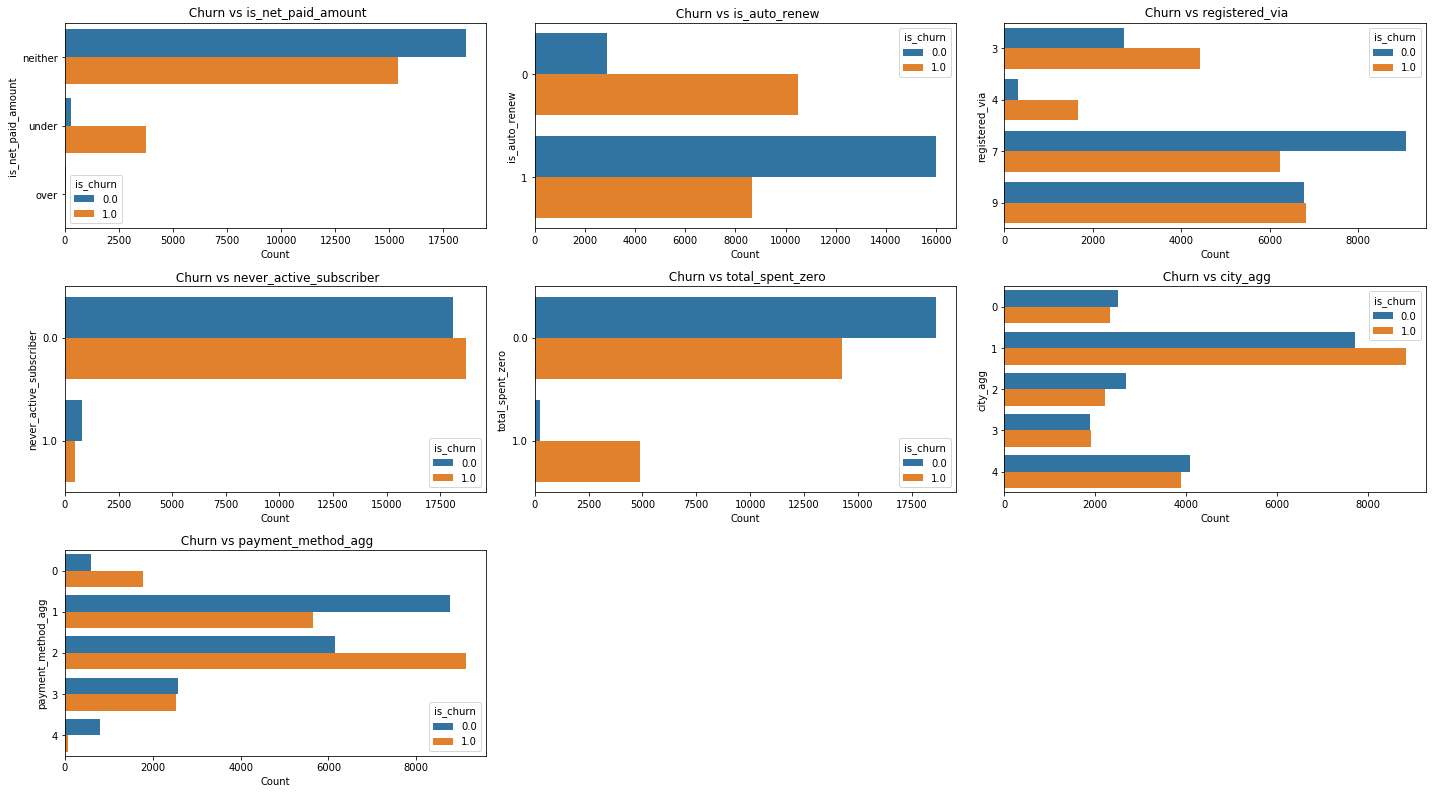


================= balancedf_2 =================


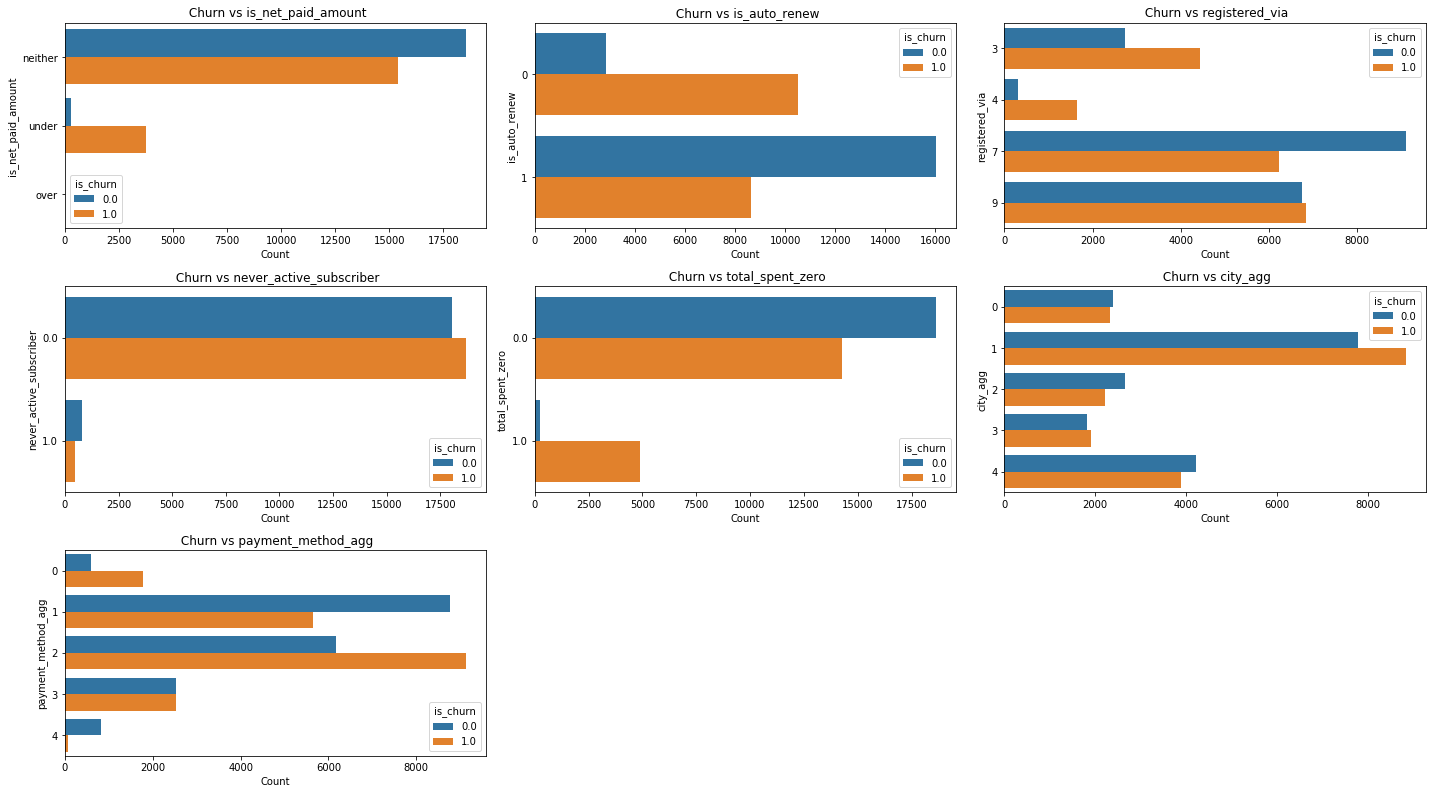


================= balancedf_3 =================


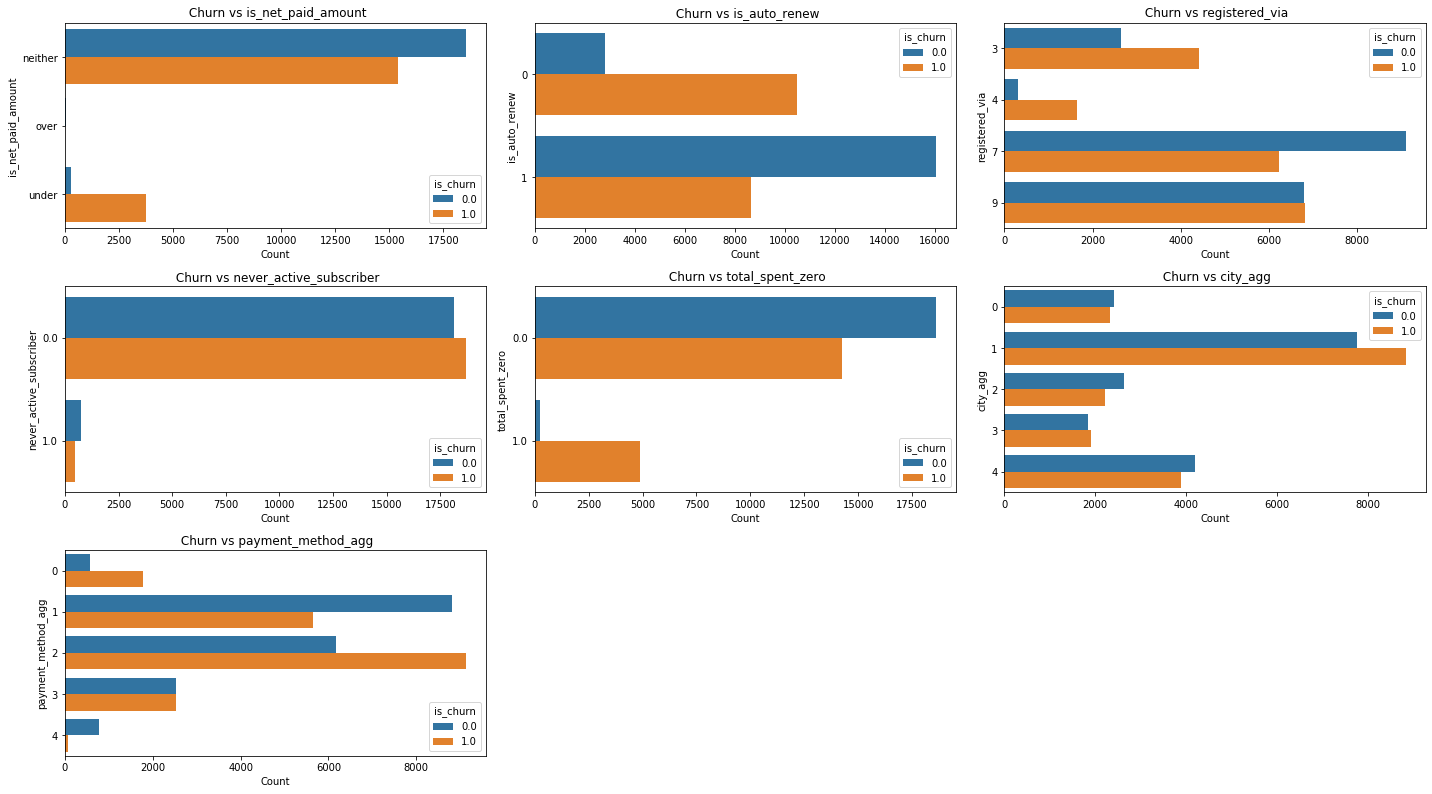

In [42]:
# Visualize is_churn vs all Categorical Features

# Iterate through sample dictionary
for name, sample in samp_dict.items():

    # Plot countplots for Feature Categories vs Churn
    print(f'\n================= {name} =================')
    plt.figure(figsize=(20,40)) 
    for index, feature in enumerate(cat_feats):
        plt.subplot(11,3,index+1)
        sns.countplot(hue='is_churn', y=feature , data=sample)
        plt.title(f" Churn vs {feature}")
        plt.ylabel(feature)
        plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

This is a great example of why we look at both Stratified and Balanced Samples. By getting rid of the imbalance we are able to see a a clearer relationship of our individual Categorical Feature values and churn. Aside from ***never_active_subscriber*** I expect all of these features to have significant influence on our model.

#### - <font color=blue>Misc. Explorations</font> -

***Never Active Subcribers***

In [ ]:
%%bigquery nas_result
SELECT 
COUNT(*) as num_of_subscribers,
SUM(plan_list_price) + SUM(net_paid_amount) as total_spent
FROM `spark-kkbox.KKbox_User_Data.DRV_Jan2016`
WHERE never_active_subscriber = 1

In [ ]:
nas_result

$18.8 Million in Lifetime Revenue from 14,459 members!

## EDA Conclusions

### - <font color=blue>Create Balanced Dataset</font> -

To avoid any class imbalance issues we will create a balanced set for model training purposes.

In [ ]:
# Query to create balanced dataset on BigQuery
for x in [1,3,5,7,9,11,13]:
    QUERY = f"""
                CREATE TABLE `spark-kkbox.KKbox_User_Data.DRV_Jan2016_{x}to1` AS
                 (SELECT 
                    *
                  FROM 
                    `spark-kkbox.KKbox_User_Data.DRV_Jan2016`
                 
                 WHERE 
                    is_churn = 0
                  ORDER BY 
                    RAND()
                  LIMIT 
                    {18865*x})

                UNION ALL

                  SELECT 
                    *
                  FROM 
                    `spark-kkbox.KKbox_User_Data.DRV_Jan2016`
                  WHERE 
                    is_churn = 1 
             """
    # Call .query() followed by .result() to trigger the 'lazy function'
    bigquery_client.query(QUERY).result()